# VaR Methodologies: Empirical investigation

# Preliminaries 

The purpose of this document is to introduce a subset of different methods -- often presented in economic literature -- that are used to backtest VaR forecasts. There will be no investigation into the adequacy of the underlying models or the data. We base our VaR forecasts on the empirical VaR estimate (quantile function) against an observation-driven approach. The observation driven approach utilize a simple GARCH(1,1) framework to model the conditional variance in a parametric VaR setup, thus yielding time-varying conditional VaR estimates. These two methods will be compared using a variety of different backtesting methodologies frequently observed within the litterature:

- Failure rates
- Unconditional & Conditional coverage test
- Failure rates based on loss functions
- The Basel Committee’s heuristic traffic light test.

As implied above, the focus will only be on univariate risk modeling. 


***


### A brief note on using the empirical VaR forecasts: 

Using the empirical quantile function under a 1000-day rolling window estimation as your VaR forecasts, you're making the implicit assumption that the distribution formed by the past 1000 days of data provide reasonable VaR forecasts. This method is equivalent to the non-parametric estimation/historical simulation method. 

**The problem:** VaR estimates produced by the above methodology is fairly insensitive to large decreases in market prices (and thus negative returns) giving you only a marginal higher VaR the day after. Only after multiple consequtive days of market tumult, will the VaR estimate start to adjust better to the current data. Decreasing the window length drastically gives the opposite response: the VaR estimates become rough and a single new data point might produce drastically different VaR forecasts. In essence, the method does not allow for predictions extending beyond the extreme returns observed during the 1000-day estimation window. 

**Conclusively**, the VaR forecasts responds slowly (*or not at all*) to new information or in the case of short window-length, might become erratic and untrustworthy. It is essential that VaR forecasts reacts well to new information over shorter horizons, in order to give traders and/or portfolio managers time to downscale their positions in case of forthcoming exogenous market events. 


While all VaR methods have advantages and disadvantages, one way of circumventing the pitfalls of VaR forecasts based on historical simulation, is to use a parametric VaR framework conditioning on the filtration up until time $t$ in order to produce $h$-step ahead $VaR_{t+h}$ forecasts.


# A Parametric VaR Approach: Forecasting VaR using a simple GARCH framework

Before diving into the GARCH framework, we will briefly define the VaR as the negative (1-$\alpha$)-quantile of an arbitrary distribution:
$$
VaR^\alpha = -F_{\alpha}^{-1}(\theta), 
$$
where $\theta$ denotes the parameters of the arbitrary continuous distribution. More strictly, the VaR can be defined as: 
$$
\mathbb{P}_{\theta}\left(R_t < -VaR\right) = \alpha,
$$
or in terms of the conditional VaR, that is used under the observation-driven approach:
$$
\mathbb{P}_{\theta}\left(R_{t+1} < -VaR_{t+1\vert t} \vert \mathcal{F}_t\right) = \alpha,
$$
where $R_t$ denotes portfolio returns, $R_t = \frac{r_{t} - r_{t-1}}{r_{t-1}}$. If one is working with log-returns you can recover the VaR via the transformation:
$$
VaR^\alpha_t = e^{\text{logret VaR}_{t}^\alpha}-1. 
$$
Throughout the small study we will be working with VaR estimates based on log-returns, since we are interested in a temporal investigation of the measure and do not perform any kind of portfolio modelling. 

There are two widely different ways of defining VaR based methods in financial literature: 

- $R_t$ denotes **returns**. In this case VaR is the left-quantile ($\alpha = 0.05$) of the empirical distribution. 
- $L_t = -R_t$ are a loss process. Then VaR is the right-quantile ($1-\alpha = 0.95$) of the distribution.

Furthermore the Expected Shortfall (ES) is the expected return (loss) below (above) the VaR for the first (second) method. When working with the first notation, it is expected to get negative VaR values. In the industry (Finance and Insurance/Actuary) VaR is often denoted as dollar risk of your position/trade and therefore negating the number is common. This is done in the above definition.  


## The GARCH framework: 
Assume that we are standing at time $t$ with information $\mathcal{F}_t$, then for a constant mean model $\mu$, we can define a univariate GARCH(1,1) framework for a return process $r_{t+1}$ as: 

\begin{align}
r_t \vert \mathcal{F}_{t-1} &= \mu + \varepsilon_t\\
\varepsilon_t &= \sigma_t \cdot z_t\\
\sigma^2_t &= \alpha_0 + \alpha_1 \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2 
\end{align}
where $z_t \overset{iid}{\sim} F(0,1)$ is a distribution with mean 0 and variance 1. For example, $F(\cdot)$ could be the standardized Student's $t$ distribution with $\nu$ degrees of freedom or a simple Gaussian distribution. The parameters of the model are obtained following QMLE and the corresponding 1-step ahead VaR forecast can be derived as follows:

$$
VaR_{t\vert t-1}^\alpha = -\mu - \hat{\sigma}_{t\vert t-1} \cdot F^{-1}_{\alpha}(\hat{\theta}),
$$
where $F^{-1}_{\alpha}(\hat{\theta})$ is the $\alpha$-quantile of the distribution of $z_{t}$ with estimated parameters $\hat{\theta}$. The GARCH framework linearly scale the quantile estimates following the mean- and variance-dynamics, giving the VaR forecasts a way to react within short horizons. The flexibility of this approach lies in the specification of a mean and variance dynamics aswell as the distribution. This is, however, also one of the shortcoming of the approach: You require knowledge of the underlying distribution and a misspecification of said distribution will lead to wrong VaR forecasts. Moreover, the distribution of the innovations needs to come from a location-scale family. 

For the purpose of the analysis, I will be using the Student's $t$ distribution for the GARCH innovations. Everything have been estimated using the `rugarch` package. Furthermore, I will be focusing on 1-step ahead VaR forecasts, when illustrating the backtesting methods. 

# Backtesting VaR: Methods and applications

A way to evaluate the performance of a given VaR methodology is to perform backtesting. That is, we compare the ex-ante estimated VaR with the ex-post realized returns. There exists several different methods and tests for backtesting VaR forecasts. These are merely the methods I have observed most in academical literature. 

## Failure rates

Failure Rates is one of the simpler ways of performing a VaR backtest. The method estimate the probability of how many times the ex-post returns $r_t$ exceeds (in absolute value) the VaR forecast over the entire forecasting period. In this sense, it is based on calculating the empirical mean of an indicator function that measures the amount of VaR violations over the entire forecast horizon $T$: 
$$
\hat{f}_l = \frac{1}{T} \sum_{t=1}^{T} I_t,
$$
with
$$
I_t=\begin{cases}
1, & \text{if } \: r_{t} < - VaR_{t\vert t-1}^\alpha\\
0, & \text{if } \: r_{t} \geq - VaR_{t\vert t-1}^\alpha
\end{cases},
$$  
where $VaR_{t\vert t-1}(\alpha)$ is the 1-step ahead VaR forecast. The closer the estimated Failure Rate $\hat{f}_l$ is to the chosen coverage level $\alpha$, the more accurate the VaR model. If the number of total ex-post losses exceeds $\alpha$\%, then the VaR model is inaccurate and underestimates the forthcoming risk. Likewise, the model can be seen as too conservative if the percentage of exceedances are less than the $\alpha$\% and thus overestimates the risk (*this is not a major issue*). The adequacy of the VaR model tested by whether the Failure Rates equates the chosen coverage level $\alpha$, can be theoretically reformulated via the conditional expectation:
$$
\mathbb{E}\left[I_t \vert \mathcal{F}_{t-1}\right] = \alpha, \label{1}
$$
which is also called the conditional coverage level for the VaR model. Alleviating the conditioning of the filtration, gives us the *unconditional coverage level*. Many of the VaR evaluation tests proposed in literature assess the adequacy of VaR
predictions by testing against different variations of the above equation.  


## Unconditional and Conditional Coverage tests
Expanding the filtration of the conditional coverage level $\mathcal{F}_{t-1} = \{I_1,\ldots,I_{t-1}\}$ it can be shown (as originally seen in the original paper of [Christoffersen (1998)](https://www.jstor.org/stable/2527341?casa_token=G2yzQO64_NcAAAAA%3Aw4S_Qf72xDK_eeDZoifvAzX6gmFZLo4Gba6-IN3GnGeMd9PXc4vTDilyUqr0FxqqThtzdSVI171UEEHu2KUA29_ZmMM5-6QNTT4MfTE2nw1k7RjAlkOE&seq=1) lemma 1) that the distribution of the conditional Failure Rates is *i.i.d* Bernoulli distributed with parameter $\alpha$:

$$
I_t \vert \mathcal{F}_{t-1} \overset{i.i.d}{\sim} Ber(\alpha).
$$

Taking iterated expectations then the formula (1) implies correct unconditional coverage of the interval forecasts. We test for correct number of violations via: 

$$
H_0: \:\: \mathbb{E}\left[I_t\right] = \alpha, \qquad H_a:  \:\: \mathbb{E}\left[I_t\right] \neq \alpha.
$$

The Likelihood Ratio (LR) statistic for verifying that $\hat{\alpha} = \alpha$ is given below, 

$$
LR_{uc} = 2 \cdot \left(\ln\left[(1-\hat{\alpha})^{n_0} \cdot \hat{\alpha}^{n_1}\right] - \ln\left[(1-\alpha)^{n_0} \cdot \alpha^{n_1}\right] \right) \overset{a}{\sim} \chi^2(1),
$$
with $n_0 = n - n_1$ and $n_1 = \sum_{i=1}^n I_i$ be the number of exceptions. Here, $\hat{\alpha} = \frac{n_1}{n}$. The null is rejected in the cases where the VaR provides too few or too many exceptions. 

**The problem** with this test statistic is the indepencence of the failure process, $I_t$. That is, the test statistic does not take into account the order of zeroes and ones, it only pays attention to the total amount of exceptions. The failure process tends to cluster in conjunction with the volatility clustering of the underlying asset. The failure rate can also cluster around time intervals where the VaR forecasts severely underestimates the forthcoming risk. 

This gives rise to the conditional coverage test of Christoffersen (1998) where the null expects the exceptions to be independently distributed through time. The test statistic can be represented in the following way (*see Louzis et al. (2011)*):

$$
LR_{cc} = 2 \left(  \ln\left[(1-\hat{\alpha}_{01})^{n_{00}} 
\hat{\alpha}_{01}^{n_{01}} (1-\hat{\alpha}_{11})^{n_{10}} \hat{\alpha}_{11}^{n_{11}}\right] - \ln\left[ (1-\alpha)^{n_0} \alpha^{n_1}\right] \right) \overset{a}{\sim} \chi^2(2),
$$ 
where $\alpha_{ij}$ denotes the transition probability between two consecutive observations from state *i* to state *j* assuming a first-order Markov chain probability transition matrix between two states (*successfull VaR estimation or an exception*), $n_{ij}$ is the number of all occcurences of transitions from state *i* to state *j* and $\hat{\alpha}_{ij} = \frac{n_{ij}}{\sum_{j=0}^1 n_{ij}}$ are the maximum likelihood estimates for $\alpha_{ij}$. The test can be seen as two tests $LR_{cc} = LR_{uc} + LR_{ind}$ where an accurate VaR model must display both the unconditional coverage property and independence of violations. 

This test has a reduced ability to detect a VaR models which only violate one of the two properties. If one of the two properties are satisfied, the test statistic finds it more difficult to detect the inadequacy of the VaR models. 

## Failure rates based on loss functions

While the above methods are good for testing the adequacy of various VaR model, they do not provide a way to directly compare the *accuracy* of each VaR model, which is a matter of regulatory concern. In the paper of [Lopez (1998)](https://www.newyorkfed.org/research/economists/medialibrary/media/research/staff_reports/research_papers/9802.pdf) he proposes to combine Failure Rates with loss functions, specifically the quadratic loss function (QLF). The general form is given by:

$$
L = \frac{1}{T} \sum_{t=1}^{T} V_t
$$ 
with 
$$
V_t=\begin{cases}
1+\left(r_t+ VaR_{t\vert t-1}^\alpha\right)^2, & \text{if } \: r_t < -VaR_{t\vert t-1}^\alpha\\
0, & \text{if} \: r_t \geq -VaR_{t \vert t-1}^\alpha
\end{cases},
$$
where $V_t$ is the QLF, which considers both the number of exceptions/violations and the magnitude as the square between the ex-post returns and the VaR forecast. The model with the smallest average QLF is considered to be the most accurate. However it needs to be noted that the methodology favours conservative models as their violations are below the user-defined $\alpha$-level.  


## The Basel Committee’s heuristic traffic light test

The Traffic light test described in a [supervisory framework](https://www.bis.org/publ/bcbs22.pdf) from the Basel Comittee was proposed in early 1996 with the purpose of providing a heuristic backtesting methodology to be used within financial institutions in order to test the adequacy of their internal VaR models.

Let $x_t = \sum_{t=1}^{250} I_t$ be the number of violations under a 250 day forecasting period. Then the adequacy of the financial institutions internal VaR model can be assessed by the heuristic piece-wise function: 
$$
TL = \begin{cases}
\text{green}, & \text{if } \: x_t \leq 4\\
\text{yellow}, & \text{if } \: 5 \leq x_t \leq 9\\
\text{red}, & \text{if } \: 10 \leq x_t 
\end{cases},
$$
where green indicates that the VaR model is to be assumed accurate, yellow is neither nor, and red indicates that the model is assumed inaccurate and needs a revision. In the original paper, these three are referred to as the green zone, yellow zone and red zone, respectively. This test is very simple and is best used as a preliminary check for the adequacy of the VaR forecasts. 


***

# Empirical analysis and Conclusion

present empirics, graphs and conclusions.

Part with stressed VaR (under stressed scenarios --> Financial Crisis etc.). 



## Libraries:

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
import os 
import csv
import pkg_resources
from scipy.stats.distributions import chi2
pkg_resources.require("scipy==1.4.1")
import scipy.stats as sc 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.precision', 4)


## Supporting functions:

In [3]:
def VaRViolations(VaR, Returns, WindowLength, Loss = False):
    """ 
    Simple function that computes binary VaRViolations with or without a quadratic loss function.

    VaR: A dataframe with VaR estimates the same length as Returns.
    Returns: A dataframe with log-returns indexed by a Date object. Date object will be used 
    WindowLength: An integer, defining the windowlength of the rolling forecast. 
    Loss: A boolean value. If true calculates Lopez (1998) VaR violations based on the quadratic loss function. 
    """
    n = len(Returns)

    VaRViolations = 1 * (-VaR[:-1].values > Returns[WindowLength+1:n].values)
    VaRViolations = pd.DataFrame(VaRViolations, index=Returns.index[WindowLength+1:n], dtype = float) #object
    VaRViolations = VaRViolations.rename({0: 'VaR Violations'}, axis = 1)

    if Loss == True:
        VaRViolations = (1 + (Returns[WindowLength+1:n].values + VaR[:-1].values)**2) * (-VaR[:-1].values > Returns[WindowLength+1:n].values)
        VaRViolations = pd.DataFrame(VaRViolations, index=Returns.index[WindowLength+1:n], dtype = float) #object
        VaRViolations = VaRViolations.rename({0: 'VaR Violations'}, axis = 1)

    return(VaRViolations)



def CoverageTest(VaRViolations, alpha, PrintToTerminal = False):
    """Computes the unconditional and conditional coverage tests by Christoffersen for VaR violations.

    Args:
        VaRViolations (dataframe or series): VaRViolations from a Dataframe or Series. 
        alpha (float): coverage level
        PrintToTerminal (bool, optional): If True prints estimates, T-stat and p-value to terminal. Defaults to False.
    """

    VaRViolations = pd.DataFrame(VaRViolations)

    n = len(VaRViolations)
    n_1 =  np.sum(VaRViolations)[0] #.values[0]
    n_0 = float(n - n_1) 
    alpha_hat = n_1 / n

    temp1 = n_0 * np.log(1-alpha_hat) + n_1 * np.log(alpha_hat)
    temp2 = n_0 * np.log(1-alpha) + n_1 * np.log(alpha)

    LR_uc = 2 * (temp1 - temp2)

    p = 1 - chi2.cdf(LR_uc, 1)

    #Conditional coverage:

    #Transitions between 4 states: staying in no-violation (0,0), transition to violation (0,1), staying in violation (1,1) and transitioning to no-violation (1,0). 
    #Code taken from https://www.financialriskforecasting.com/code/PythonJulia8.html
    V = VaRViolations.values
    J = np.full([n, 4], 0)

    for i in range(1, len(VaRViolations)-1,1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)

    n_00 = np.sum(J[:,0])
    n_01 = np.sum(J[:,1]) 
    n_10 = np.sum(J[:,2])
    n_11 = np.sum(J[:,3])

    #alpha_hat_00 = n_00 / (n_00 + n_01)
    alpha_hat_01 = n_01 / (n_00 + n_01)
    #alpha_hat_10 = n_10 / (n_10 + n_11)
    alpha_hat_11 = n_11 / (n_10 + n_11)

    alpha_hat_cc = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)

    temp1 = n_00 * np.log(1-alpha_hat_01) + n_01 * np.log(alpha_hat_01) + n_10 * np.log(1-alpha_hat_11) + n_11 * np.log(alpha_hat_11)

    LR_cc = 2 * (temp1 - temp2)
    
    p_cc = 1 - chi2.cdf(LR_cc, 2)

    output, output_cc = [alpha_hat, LR_uc, p], [alpha_hat_cc, LR_cc, p_cc]

    df = pd.DataFrame([pd.Series([alpha_hat, LR_uc, p]),
                      pd.Series([alpha_hat_cc, LR_cc, p_cc])])
    
    df.columns = ["Alpha hat", "Statistic", "p-value"]
    df.index = ["Unconditional", "Conditional"]


    final = np.vstack([output, output_cc])
    text = [ "Unconditional", "Conditional  "]


    if PrintToTerminal == True:
        print('                alpha_hat      Statistic     p-value')
        for i in range(2):
            print('{0:<11}   {1:0.4f}      {2: 0.4f}    {3: 0.4f}'.format(text[i], final[i, 0], final[i, 1], final[i, 2]))

    return(df)



## Downloading SPY prices:

In [204]:
SPYPrices = yf.download("SPY", start = "1997-01-01", end = "2022-04-01")['Adj Close']

SPY = pd.DataFrame(SPYPrices)

[*********************100%***********************]  1 of 1 completed


In [205]:
#Gross returns/ Linear returns 
#SPYreturns = 100 * SPY.pct_change().dropna()

SPYLogreturns = pd.DataFrame(100 * np.diff(np.log(SPY['Adj Close'])))
SPYLogreturns.columns = ['Log-Returns']; 
SPYLogreturns.index = SPY.iloc[1:, ].index
SPYLogreturns.head()

,Log-Returns
Date,
1997-01-02,0.2535
1997-01-03,1.4250
1997-01-06,-0.8777
1997-01-07,1.2102
1997-01-08,-0.8748


## VaR investigation on SPY:

### VaR based on Gaussian and Student's *t* distribution

In [206]:
#We do a rolling 1-step ahead Gaussian VaR forecasts of SPY. Here, the lookback window is set to 8 years: 
WindowLength = 252 * 8
n = len(SPYLogreturns)

estimates = []
for i in range(WindowLength, n, 1):
    temp = SPYLogreturns.iloc[(i - WindowLength):i]
    mu, std = sc.norm.fit(temp)
    estimates.append([mu, std])


estimates = np.array(estimates)

#Gaussian 95% VaR Rolling estimates. 
VaRNormal_95 =  pd.DataFrame(- sc.norm.ppf(0.05, loc = estimates[:,0], scale = estimates[:,1]))
VaRNormal_95 = VaRNormal_95.set_index(SPYLogreturns.index[WindowLength:])
VaRNormal_95 = VaRNormal_95.rename({0: 'VaR Normal 95%'}, axis = 1)

#Gaussian 99% VaR Rolling estimates. 
VaRNormal_99 =  pd.DataFrame(- sc.norm.ppf(0.01, loc = estimates[:,0], scale = estimates[:,1]))
VaRNormal_99 = VaRNormal_99.set_index(SPYLogreturns.index[WindowLength:])
VaRNormal_99 = VaRNormal_99.rename({0: 'VaR Normal 99%'}, axis = 1)

### VaR based on GARCH(1,1) model with *t*-distributed innovations

In [207]:
#Comparing to the 1-step ahead VaR forecasts of a GARCH(1,1) model with t-distributed innovations: 
GarchModel = arch_model(y = SPYLogreturns, mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

#Last observation to fit the GARCH model is day number 1000: 
#GarchFit = GarchModel.fit(last_obs=SPYLogreturns.index[WindowLength], update_freq=1, disp='off')


#Rolling forecasts see p. 30 here, https://readthedocs.org/projects/arch/downloads/pdf/latest/ 
#Parametric VaR at p. 34. 
#Remember horizon=3 implies that it forecasts recursively 3 periods ahead. Set horizon = 1. 
#Scipy have been downgraded to 1.4.1 in order to avoid "ValueError: x0 violates bound constraints."

forecasts = {}
paramEstimates = []
for i in range(WindowLength, n, 1):
    # print(i)
    sys.stdout.flush()
    res = GarchModel.fit(first_obs=(i - WindowLength), last_obs=i, disp="off")
    paramEstimates.append(res.params.transpose())
    temp = res.forecast(horizon=1, reindex=False, method='analytic').variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

paramEstimates = pd.DataFrame(paramEstimates)
paramEstimates = paramEstimates.set_index(SPYLogreturns.index[WindowLength:]) 

forecasts = pd.DataFrame(forecasts).T


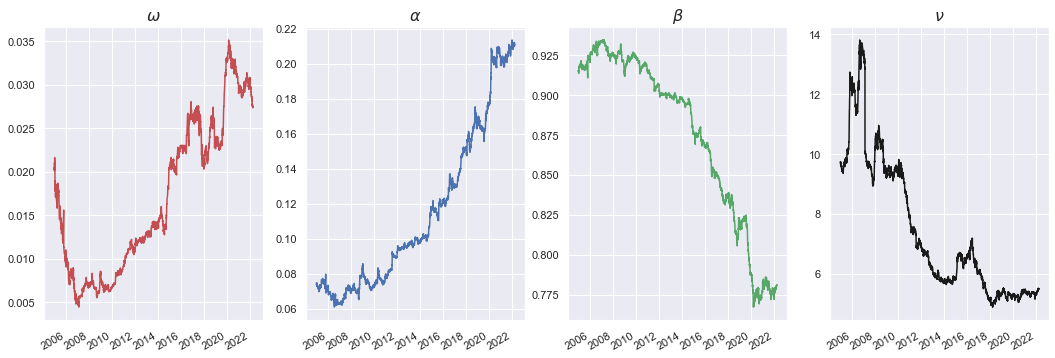

In [208]:
# Plot the evolution of the parameter estimates here. Do 1 x 4 plots.
#paramEstimates.head()

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(18,6))

ax[0].plot(SPYLogreturns.index[WindowLength:], paramEstimates['omega'], 'r') #row=0, col=0
ax[1].plot(SPYLogreturns.index[WindowLength:], paramEstimates['alpha[1]'], 'b') #row=1, col=0
ax[2].plot(SPYLogreturns.index[WindowLength:], paramEstimates['beta[1]'], 'g') #row=0, col=1
ax[3].plot(SPYLogreturns.index[WindowLength:], paramEstimates['nu'], 'k') #row=1, col=1
ax[0].set_title(r'$\omega$', fontsize = 16)
ax[1].set_title(r'$\alpha$', fontsize = 16)
ax[2].set_title(r'$\beta$', fontsize = 16)
ax[3].set_title(r'$\nu$', fontsize = 16)

fig.autofmt_xdate()

plt.show()


### Out-of-sample VaR forecasting based on the GARCH(1,1) with Student's t-distributed innovations

In [209]:
# Getting VaR estimate
StudentsTvalues_95 = []
StudentsTvalues_99 = []

for i in range(0, n-WindowLength, 1):
    StudentsTvalues_95.append(-GarchModel.distribution.ppf(0.05, paramEstimates['nu'].iloc[i]))
    StudentsTvalues_99.append(-GarchModel.distribution.ppf(0.01, paramEstimates['nu'].iloc[i]))

StudentsTvalues_95 = pd.DataFrame(StudentsTvalues_95)
StudentsTvalues_99 = pd.DataFrame(StudentsTvalues_99)


#We will negate the term in the analysis.
VaR_Garch_95 =  np.mean(SPYLogreturns).values + np.sqrt(forecasts).values * StudentsTvalues_95

VaR_Garch_95 = VaR_Garch_95.set_index(SPYLogreturns.index[WindowLength:])
VaR_Garch_95 = pd.DataFrame(VaR_Garch_95)
VaR_Garch_95 = VaR_Garch_95.rename({0: 'VaR GARCH 95%'}, axis = 1)

VaR_Garch_99 =  np.mean(SPYLogreturns).values + np.sqrt(forecasts).values * StudentsTvalues_99

VaR_Garch_99 = VaR_Garch_99.set_index(SPYLogreturns.index[WindowLength:])
VaR_Garch_99 = pd.DataFrame(VaR_Garch_99)
VaR_Garch_99 = VaR_Garch_99.rename({0: 'VaR GARCH 99%'}, axis = 1)



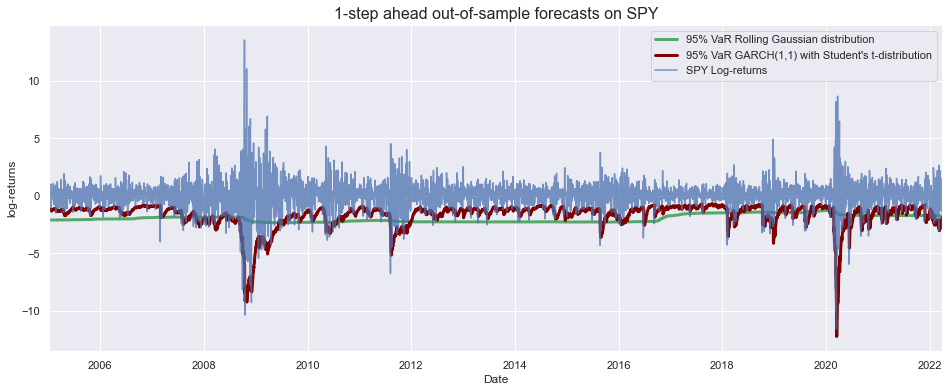

In [210]:
# VaR estimated ex-post at day 2000 is to be used for day 2001. Therefore we have moved the returns by one day, in order to compare the VaR estimates to the realized log-return values.  
sns.set()
sns.color_palette('dark')
plt.figure(figsize=(16,6))
plt.margins(x=0)
plt.plot(SPYLogreturns.index[WindowLength+1:], -VaRNormal_95[:-1], color = 'g', label = '95% VaR Rolling Gaussian distribution', linewidth = 3) 
plt.plot(SPYLogreturns.index[WindowLength+1:], -VaR_Garch_95[:-1], color = 'maroon', label = "95% VaR GARCH(1,1) with Student's t-distribution", linewidth = 3) #color = 'darkred'
plt.plot(SPYLogreturns.index[WindowLength+1:], SPYLogreturns[WindowLength+1:n], color = 'b', label = 'SPY Log-returns', alpha = 0.75) #color = 'steelblue'
plt.legend()
plt.title('1-step ahead out-of-sample forecasts on SPY', fontsize = 16)
plt.ylabel('log-returns')
plt.xlabel('Date')
plt.show()

### Backtesting VaR models on SPY

#### Failure rates based on the Quadratic loss function

In [211]:
GarchLoss_95 = VaRViolations(VaR_Garch_95, SPYLogreturns, WindowLength, Loss=True)
NormalLoss_95 = VaRViolations(VaRNormal_95, SPYLogreturns, WindowLength, Loss=True)

GarchLoss_99 = VaRViolations(VaR_Garch_99, SPYLogreturns, WindowLength, Loss=True)
NormalLoss_99 = VaRViolations(VaRNormal_99, SPYLogreturns, WindowLength, Loss=True)


data = pd.concat([NormalLoss_95, NormalLoss_99, GarchLoss_95, GarchLoss_99], axis = 1)

data.columns = ["Gaussian 95%", "Gaussian 99%", "GARCH 95%", "GARCH 99%"]

Averages = pd.concat([data.mean(), data[data > 0].mean()], axis = 1) 
Averages.columns = ["Averages for all days", "Averages only for distressed days"]

Averages

,Averages for all days,Averages only for distressed days
Gaussian 95%,0.2351,5.2578
Gaussian 99%,0.1459,6.5919
GARCH 95%,0.1106,2.1423
GARCH 99%,0.0307,1.9878


#### Basel Trafic light test

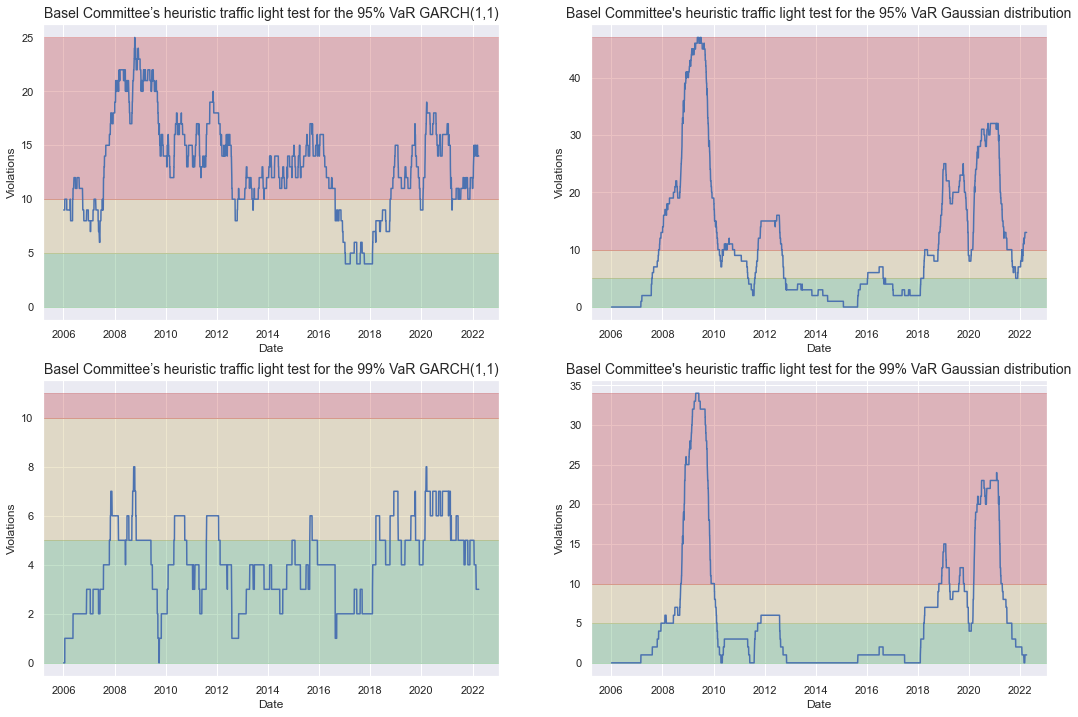

In [212]:
#Doing BASEL test under a rolling forecast period of 250 days. 


GarchViolations_95 = VaRViolations(VaR_Garch_95, SPYLogreturns, WindowLength, Loss=False)
xTGarch_95 = GarchViolations_95.rolling(250).sum()
maxTestGarch_95 = xTGarch_95.max()

NormalViolations_95 = VaRViolations(VaRNormal_95, SPYLogreturns, WindowLength, Loss=False)
xTNormal_95 = NormalViolations_95.rolling(250).sum()
maxTestNormal_95 = xTNormal_95.max()


GarchViolations_99 = VaRViolations(VaR_Garch_99, SPYLogreturns, WindowLength, Loss=False)
xTGarch_99 = GarchViolations_99.rolling(250).sum()
maxTestGarch_99 = xTGarch_99.max()

NormalViolations_99 = VaRViolations(VaRNormal_99, SPYLogreturns, WindowLength, Loss=False)
xTNormal_99 = NormalViolations_99.rolling(250).sum()
maxTestNormal_99 = xTNormal_99.max()



fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18,12))
ax[0, 0].plot(xTGarch_95)
ax[0, 0].axhspan(0,5, color = 'g', alpha = 0.35)
ax[0, 0].axhspan(5,10, color = 'y', alpha = 0.35)
ax[0, 0].axhspan(10, maxTestGarch_95, color = 'r', alpha = 0.35)
ax[0, 0].set_title('Basel Committee’s heuristic traffic light test for the 95% VaR GARCH(1,1)', fontsize = 14)
ax[0, 0].set(xlabel = 'Date', ylabel = 'Violations') 

ax[0, 1].plot(xTNormal_95)
ax[0, 1].axhspan(0,5, color = 'g', alpha = 0.35)
ax[0, 1].axhspan(5,10, color = 'y', alpha = 0.35)
ax[0, 1].axhspan(10, maxTestNormal_95, color = 'r', alpha = 0.35)
ax[0, 1].set_title("Basel Committee's heuristic traffic light test for the 95% VaR Gaussian distribution", fontsize = 14)
ax[0, 1].set(xlabel = 'Date', ylabel = 'Violations') 

ax[1,0].plot(xTGarch_99)
ax[1,0].axhspan(0,5, color = 'g', alpha = 0.35)
ax[1,0].axhspan(5,10, color = 'y', alpha = 0.35)
ax[1,0].axhspan(10, 11, color = 'r', alpha = 0.35)
ax[1,0].set_title('Basel Committee’s heuristic traffic light test for the 99% VaR GARCH(1,1)', fontsize = 14)
ax[1,0].set(xlabel = 'Date', ylabel = 'Violations') 

ax[1, 1].plot(xTNormal_99)
ax[1, 1].axhspan(0,5, color = 'g', alpha = 0.35)
ax[1, 1].axhspan(5,10, color = 'y', alpha = 0.35)
ax[1, 1].axhspan(10, maxTestNormal_99, color = 'r', alpha = 0.35)
ax[1, 1].set_title("Basel Committee's heuristic traffic light test for the 99% VaR Gaussian distribution", fontsize = 14)
ax[1, 1].set(xlabel = 'Date', ylabel = 'Violations') 


plt.show()




#### Unconditional and Conditional Coverage test:

In [213]:
CT_Garch95 = CoverageTest(GarchViolations_95, 0.05, False)
CT_Garch99 = CoverageTest(GarchViolations_99, 0.01, False)

CT_Normal95 = CoverageTest(NormalViolations_95, 0.05, False)
CT_Normal99 = CoverageTest(NormalViolations_99, 0.01, False)

df1 = pd.concat([CT_Garch95, CT_Normal95])
df2 = pd.concat([CT_Garch99, CT_Normal99])

df3 = pd.concat([df1, df2], axis = 1)

df3.index = pd.MultiIndex.from_product([['GARCH', 'Gaussian'], ['Unconditional', 'Conditional']])
df3.columns = pd.MultiIndex.from_product([ ["95% Value at Risk", "99% Value at Risk"], ["Alpha hat","T-stat", "p-value"]], names = [" ", "Statistics"])
df3.style.set_properties(**{'text-align': 'center'})

df3.style

## A happy coincidence? Backtesting VaR models on multiple equities

### Calculating VaR statistics across 2000+ stocks

**Long computations are skipped. They have been done previously.**

In [5]:
os.chdir("C:/Users/Emil/Desktop/Data for Analysis")
StockData = pd.read_csv("AdjCloseLargeStockDB.csv")
StockData = StockData.set_index('Date')


In [6]:
#Need 8 years of data 252 * 8 + 252 * 2 days out of sample (rule of thumb). 
StockData = StockData.loc[:, StockData.count() >= (252 * 8 + 252 * 2)]
StockData = np.log(StockData).diff() * 100
StockData.drop('1996-12-31', axis = 0, inplace = True)

In [7]:
%%script echo skipping
## Things have already been estimated, and are thus loaded below. 

#Estimating Gaussian distribution parameters for 2000+ stocks: 
# Running this once, then saving it as a pkl file.
Large_Gaussian_Estimates = {}

for j in range(0, StockData.shape[1], 1): #StockData.shape[1]

    n = len(StockData.iloc[:,j].dropna())
    estimates = {}

    for i in range(WindowLength, n, 1):
        temp = StockData.iloc[:,j].dropna()
        temp = temp.iloc[(i - WindowLength):i]
        cast = sc.norm.fit(temp)
        estimates[temp.index[-1]] = cast
        #estimates.append([temp.index[i], mu, std])
    estimates = pd.DataFrame(estimates).T
    estimates = estimates.set_index(pd.to_datetime(estimates.index))
    
    #estimates = np.array(estimates)

    Large_Gaussian_Estimates[StockData.columns[j]] = estimates   

#time: 38 mins

skipping


In [8]:
%%script echo skipping
#Converting to dataframe
Large_Gaussian_Estimates_DF = pd.concat([pd.DataFrame(v) for k, v in Large_Gaussian_Estimates.items()], axis = 1, join = 'outer', keys = list(Large_Gaussian_Estimates.keys()))
Large_Gaussian_Estimates_DF = Large_Gaussian_Estimates_DF.rename(columns={0: "Mu", 1: "Sigma"})
#Large_Gaussian_Estimates_DF = Large_Gaussian_Estimates_DF.set_index(StockData.index[WindowLength:n])

skipping


In [9]:
#Large_Gaussian_Estimates_DF.to_pickle("Large_Gaussian_Estimates_DF.pkl")
Large_Gaussian_Estimates_DF = pd.read_pickle("Large_Gaussian_Estimates_DF.pkl")
Large_Gaussian_Estimates_DF

A              AA             AAL            AAON          \
                Mu   Sigma      Mu   Sigma      Mu   Sigma      Mu   Sigma   
2005-01-05     NaN     NaN  0.0387  2.3928     NaN     NaN  0.0955  3.0208   
2005-01-06     NaN     NaN  0.0379  2.3923     NaN     NaN  0.0960  3.0204   
2005-01-07     NaN     NaN  0.0362  2.3905     NaN     NaN  0.0954  3.0205   
2005-01-10     NaN     NaN  0.0360  2.3906     NaN     NaN  0.0946  3.0204   
2005-01-11     NaN     NaN  0.0349  2.3913     NaN     NaN  0.0933  3.0205   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2022-03-24  0.0650  1.5778  0.0608  3.2165 -0.0362  3.2244  0.0534  2.0528   
2022-03-25  0.0648  1.5778  0.0591  3.2174 -0.0368  3.2240  0.0525  2.0530   
2022-03-28  0.0647  1.5778  0.0600  3.2172 -0.0344  3.2234  0.0540  2.0518   
2022-03-29  0.0662  1.5784  0.0558  3.2151 -0.0307  3.2248  0.0580  2.0580   
2022-03-30  0.0651  1.5792  0.0574  3.2154 -0.0305  3.2247  0.0583  2.0579   

               AAP          ... ZGNX          ZION            ZNGA          \
                Mu   Sigma  ...   Mu Sigma      Mu   Sigma      Mu   Sigma   
2005-01-05     NaN     NaN  ...  NaN   NaN  0.0529  2.1515     NaN     NaN   
2005-01-06     NaN     NaN  ...  NaN   NaN  0.0538  2.1514     NaN     NaN   
2005-01-07     NaN     NaN  ...  NaN   NaN  0.0518  2.1519     NaN     NaN   
2005-01-10     NaN     NaN  ...  NaN   NaN  0.0507  2.1512     NaN     NaN   
2005-01-11     NaN     NaN  ...  NaN   NaN  0.0505  2.1512     NaN     NaN   
...            ...     ...  ...  ...   ...     ...     ...     ...     ...   
2022-03-24  0.0289  2.0504  ...  NaN   NaN  0.0469  2.1212  0.0327  2.4533   
2022-03-25  0.0296  2.0503  ...  NaN   NaN  0.0482  2.1226  0.0318  2.4525   
2022-03-28  0.0287  2.0509  ...  NaN   NaN  0.0479  2.1228  0.0343  2.4508   
2022-03-29  0.0294  2.0515  ...  NaN   NaN  0.0485  2.1226  0.0361  2.4493   
2022-03-30  0.0283  2.0518  ...  NaN   NaN  0.0460  2.1238  0.0365  2.4492   

              ZUMZ            ZYXI          
                Mu   Sigma      Mu   Sigma  
2005-01-05     NaN     NaN     NaN     NaN  
2005-01-06     NaN     NaN     NaN     NaN  
2005-01-07     NaN     NaN     NaN     NaN  
2005-01-10     NaN     NaN     NaN     NaN  
2005-01-11     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...  
2022-03-24  0.0221  3.2120  0.1643  6.8277  
2022-03-25  0.0234  3.2112  0.1680  6.8252  
2022-03-28  0.0250  3.2114  0.1669  6.8254  
2022-03-29  0.0273  3.2120  0.1687  6.8247  
2022-03-30  0.0249  3.2138  0.1704  6.8240  

[4339 rows x 4378 columns]

In [10]:
%%script echo skipping
#Estimating the GARCH model. 

Large_GARCH_Estimates = {}
Large_GARCH_Forecasts = {}
for j in range(0, StockData.shape[1]+1, 1): #StockData.shape[1]

    n = len(StockData.iloc[:,j].dropna())
    estimates = []
    forecasts = {}
    GarchModel = arch_model(y = StockData.iloc[:,j].dropna(), mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

    for i in range(WindowLength, n, 1):
        sys.stdout.flush()
        res = GarchModel.fit(first_obs=(i - WindowLength), last_obs=i, disp="off")
        estimates.append(res.params.transpose())
        temp = res.forecast(horizon=1, reindex=False, method='analytic').variance
        fcast = temp.iloc[0]
        forecasts[fcast.name] = fcast


    forecasts = pd.DataFrame(forecasts).T
    forecasts = forecasts.set_index(pd.to_datetime(forecasts.index))

    estimates = pd.DataFrame(estimates)
    estimates = estimates.set_index(pd.to_datetime(forecasts.index))

    Large_GARCH_Forecasts[StockData.columns[j]] = forecasts
    Large_GARCH_Estimates[StockData.columns[j]] = estimates   
    print("Iteration", j, "Out of",StockData.shape[1])

#2 days 14 hours.
#3660m 47s


skipping


In [11]:
%%script echo skipping
Large_GARCH_Estimates_DF = pd.concat([pd.DataFrame(v) for k, v in Large_GARCH_Estimates.items()], axis = 1, keys = list(Large_GARCH_Estimates.keys()))
Large_GARCH_Forecasts_DF = pd.concat([pd.DataFrame(v) for k, v in Large_GARCH_Forecasts.items()], axis = 1, keys = list(Large_GARCH_Forecasts.keys()))
#Large_GARCH_Estimates_DF

skipping


In [12]:
#Large_GARCH_Estimates_DF.to_pickle("Large_GARCH_Estimates_DF.pkl")
#Large_GARCH_Forecasts_DF.to_pickle("Large_GARCH_Forecasts_DF.pkl")
Large_GARCH_Estimates_DF = pd.read_pickle("Large_GARCH_Estimates_DF.pkl")
Large_GARCH_Forecasts_DF = pd.read_pickle("Large_GARCH_Forecasts_DF.pkl")



In [13]:
%%script echo skipping
Large_VaRNormal95 = pd.DataFrame() 
Large_VaRNormal99 = pd.DataFrame() 


for name, col in Large_Gaussian_Estimates_DF:
    temp = pd.DataFrame(-sc.norm.ppf(0.05, loc = Large_Gaussian_Estimates_DF[name]["Mu"], scale = Large_Gaussian_Estimates_DF[name]["Sigma"]))
    temp.columns = [name] 
    Large_VaRNormal95 = pd.concat([Large_VaRNormal95, temp], axis = 1)

    temp2 = pd.DataFrame(-sc.norm.ppf(0.01, loc = Large_Gaussian_Estimates_DF[name]["Mu"], scale = Large_Gaussian_Estimates_DF[name]["Sigma"]))
    temp2.columns = [name] 
    Large_VaRNormal99 = pd.concat([Large_VaRNormal99, temp2], axis = 1)

Large_VaRNormal95 = Large_VaRNormal95.set_index(Large_Gaussian_Estimates_DF.index)
Large_VaRNormal99 = Large_VaRNormal99.set_index(Large_Gaussian_Estimates_DF.index)

skipping


In [14]:
#Large_VaRNormal95.to_pickle("Large_VaRNormal95.pkl")
#Large_VaRNormal99.to_pickle("Large_VaRNormal99.pkl")
Large_VaRNormal95 = pd.read_pickle("Large_VaRNormal95.pkl")
Large_VaRNormal99 = pd.read_pickle("Large_VaRNormal99.pkl")

#Duplicates happened, quick fix:
Large_VaRNormal95 = Large_VaRNormal95.loc[:,~Large_VaRNormal95.columns.duplicated()]
Large_VaRNormal99 = Large_VaRNormal99.loc[:,~Large_VaRNormal99.columns.duplicated()]


In [15]:
%%script echo skipping

Large_VaR_Garch_95 = {}
Large_VaR_Garch_99 = {}

for name in StockData: 

    GarchModel = arch_model(y = StockData[name].dropna(), mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

    StudentsTvalues_95 = []
    StudentsTvalues_99 = []

    nNaNs = len(Large_GARCH_Estimates_DF[name]['nu'].dropna())
    for i in range(0, nNaNs, 1):
        StudentsTvalues_95.append(-GarchModel.distribution.ppf(0.05, Large_GARCH_Estimates_DF[name]['nu'].dropna().iloc[i]))
        StudentsTvalues_99.append(-GarchModel.distribution.ppf(0.01, Large_GARCH_Estimates_DF[name]['nu'].dropna().iloc[i]))


    Values_Garch_95 = np.mean(StockData[name].dropna()) + np.sqrt(Large_GARCH_Forecasts_DF[name].dropna()).multiply(StudentsTvalues_95, axis = 0)
    Values_Garch_99 = np.mean(StockData[name].dropna()) + np.sqrt(Large_GARCH_Forecasts_DF[name].dropna()).multiply(StudentsTvalues_99, axis = 0)


    Large_VaR_Garch_95[name] = Values_Garch_95
    Large_VaR_Garch_99[name] = Values_Garch_99


#364m 43s

skipping


In [16]:
%%script echo skipping

Large_VaR_Garch_95_DF = pd.concat([pd.DataFrame(v) for k,v in Large_VaR_Garch_95.items()], axis = 1) #keys = list(Large_VaR_Garch_95.keys())
Large_VaR_Garch_95_DF.columns = Large_VaR_Garch_95.keys()

Large_VaR_Garch_99_DF = pd.concat([pd.DataFrame(v) for k,v in Large_VaR_Garch_99.items()], axis = 1) #keys = list(Large_VaR_Garch_99.keys())
Large_VaR_Garch_99_DF.columns = Large_VaR_Garch_99.keys()

Large_VaR_Garch_95_DF.to_pickle("Large_VaR_Garch_95_DF.pkl")
Large_VaR_Garch_99_DF.to_pickle("Large_VaR_Garch_99_DF.pkl")



skipping


In [17]:
Large_VaR_Garch_95_DF = pd.read_pickle("Large_VaR_Garch_95_DF.pkl")
Large_VaR_Garch_99_DF = pd.read_pickle("Large_VaR_Garch_99_DF.pkl")

Large_VaR_Garch_99_DF

,A,AA,AAL,AAON,AAP,AAPL,AAT,AAU,AAWW,AAXJ,...,YVR,ZBH,ZBRA,ZEUS,ZG,ZGNX,ZION,ZNGA,ZUMZ,ZYXI
2005-01-05,NaN,3.7625,NaN,8.0745,NaN,6.8524,NaN,NaN,NaN,NaN,...,9.7380,NaN,6.1502,13.0282,NaN,NaN,3.1595,NaN,NaN,NaN
2005-01-06,NaN,3.7116,NaN,7.7975,NaN,6.7398,NaN,NaN,NaN,NaN,...,10.6384,NaN,6.1004,12.4514,NaN,NaN,3.0986,NaN,NaN,NaN
2005-01-07,NaN,3.7106,NaN,7.5742,NaN,9.5318,NaN,NaN,NaN,NaN,...,11.1226,NaN,6.0672,11.8666,NaN,NaN,3.7339,NaN,NaN,NaN
2005-01-10,NaN,3.6666,NaN,7.2923,NaN,8.6060,NaN,NaN,NaN,NaN,...,11.1430,NaN,6.0429,11.3851,NaN,NaN,3.5843,NaN,NaN,NaN
2005-01-11,NaN,3.8852,NaN,7.3127,NaN,10.1763,NaN,NaN,NaN,NaN,...,10.9271,NaN,6.1706,12.9124,NaN,NaN,3.4406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,5.3967,11.7564,10.4299,5.9759,5.0093,5.4234,3.1824,22.1412,6.0750,5.9506,...,22.4231,4.3948,7.2912,11.9280,10.8669,NaN,6.3771,5.1006,8.6242,13.5364
2022-03-25,5.0192,11.6300,10.0381,5.7637,4.9363,5.0998,3.5712,21.3306,5.9650,5.5646,...,22.1996,4.2817,6.8081,12.0539,11.1849,NaN,6.7443,5.2373,8.5715,12.7300
2022-03-28,4.6652,11.3536,9.6684,5.5056,4.9900,4.8174,3.4273,20.4674,5.8560,5.1350,...,19.9370,4.1229,6.4469,11.8087,10.8944,NaN,6.5427,5.2540,8.5311,13.1390
2022-03-29,4.7879,11.1142,9.8981,7.3805,5.0357,4.8790,4.9743,19.7599,5.7412,4.9974,...,18.2057,4.6176,7.0613,11.5222,11.0068,NaN,6.1431,5.1532,8.5315,12.6483


### Backtesting VaR models on 2000+ equities

In [18]:
#Note to self. We are only gonna pursue 99% VaR

# Failure rates: 
WindowLength = 252 * 8

names = Large_VaR_Garch_99_DF.columns
Large_VaRViolations_Garch99_DF = pd.concat([VaRViolations(Large_VaR_Garch_99_DF.loc[:, name], StockData.loc[:, name], WindowLength, Loss = True) for name in names], axis = 1)
Large_VaRViolations_Garch99_DF.columns = names 

Large_Garch99_SummaryStatistics = Large_VaRViolations_Garch99_DF.describe(include = 'all', datetime_is_numeric=False).loc[["mean", "std", "max"],:]
Large_Garch99_SummaryStatistics.columns = names 


Large_VaRViolations_Normal99_DF = pd.concat([VaRViolations(Large_VaRNormal99.loc[:, name], StockData.loc[:, name], WindowLength, Loss = True) for name in names], axis = 1)
Large_Normal99_DF_SummaryStatistics = Large_VaRViolations_Normal99_DF.describe(include='all', datetime_is_numeric=False).loc[["mean", "std", "max"],:]
Large_Normal99_DF_SummaryStatistics.columns = names 
Large_VaRViolations_Normal99_DF.columns = names 


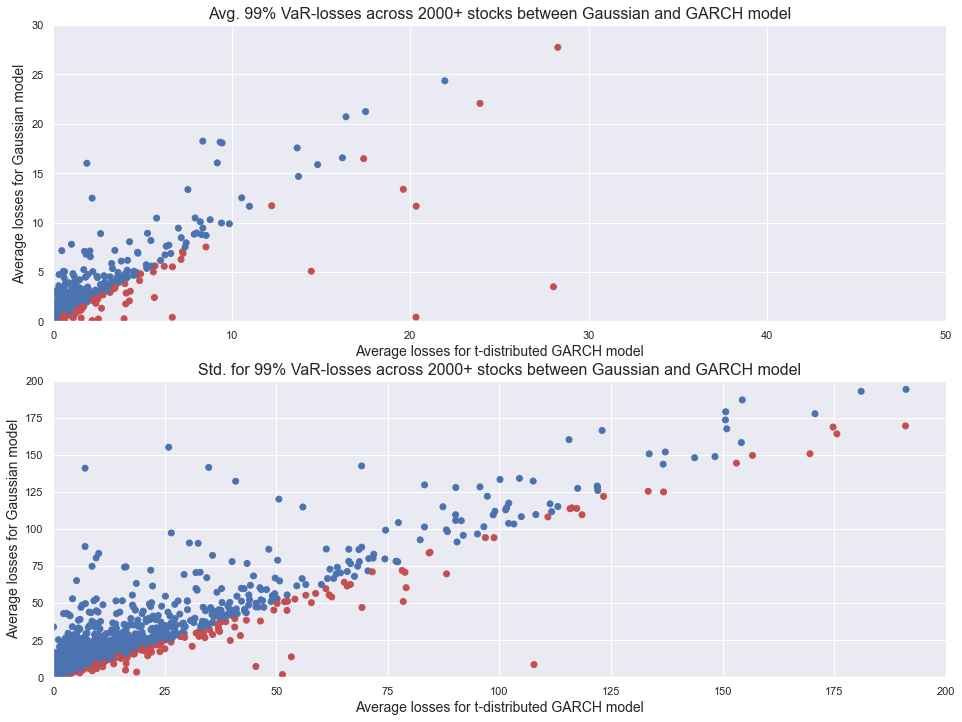

In [215]:
#StockData
AvgExceedance_GARCH = pd.concat([Large_Garch99_SummaryStatistics.loc["mean", :], Large_Normal99_DF_SummaryStatistics.loc["mean",:]], axis = 1)
AvgExceedance_GARCH = (AvgExceedance_GARCH.iloc[:,0] > AvgExceedance_GARCH.iloc[:,1]).values * 1
col = np.where(AvgExceedance_GARCH == 1, 'r', 'b') 

StdExceedance_GARCH = pd.concat([Large_Garch99_SummaryStatistics.loc["std", :], Large_Normal99_DF_SummaryStatistics.loc["std",:]], axis = 1)
StdExceedance_GARCH = (StdExceedance_GARCH.iloc[:,0] > StdExceedance_GARCH.iloc[:,1]).values * 1
col2 = np.where(StdExceedance_GARCH == 1, 'r', 'b') 


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,12))
sns.set()
sns.color_palette('dark')
ax[0].margins(x=0)
ax[0].scatter(x = Large_Garch99_SummaryStatistics.loc["mean", :], y = Large_Normal99_DF_SummaryStatistics.loc["mean",:], c = col)
ax[0].set_title('Avg. 99% VaR-losses across 2000+ stocks between Gaussian and GARCH model', fontsize = 16)
ax[0].set_xlabel('Average losses for t-distributed GARCH model', fontsize = 14) 
ax[0].set_ylabel('Average losses for Gaussian model', fontsize = 14) 
ax[0].set_ylim([0,30])
ax[0].set_xlim([0,50])

ax[1].margins(x=0.1)
ax[1].scatter(x = Large_Garch99_SummaryStatistics.loc["std", :], y = Large_Normal99_DF_SummaryStatistics.loc["std",:], c = col2)
ax[1].set_title('Std. for 99% VaR-losses across 2000+ stocks between Gaussian and GARCH model', fontsize = 16)
ax[1].set_xlabel('Average losses for t-distributed GARCH model', fontsize = 14) 
ax[1].set_ylabel('Average losses for Gaussian model', fontsize = 14) 
ax[1].set_ylim([0,200])
ax[1].set_xlim([0,200])


plt.show()
# Red points show the places where the average losses (or standard deviation) for the GARCH model exceeded the average loss (or standard deviation) for the Gaussian model. 128/2189 instances was found for average losses. 

In [195]:
DistressedDays_GARCH99 = [Large_VaRViolations_Garch99_DF.loc[(Large_VaRViolations_Garch99_DF.loc[:, name] > 0), name].mean() for name in names] 
DistressedDays_Normal99 = [Large_VaRViolations_Normal99_DF.loc[(Large_VaRViolations_Normal99_DF.loc[:, name] > 0), name].mean() for name in names] 

table = pd.concat([Large_Normal99_DF_SummaryStatistics.loc['mean',:], pd.DataFrame(DistressedDays_Normal99, index = names), Large_Garch99_SummaryStatistics.loc['mean', :], 
pd.DataFrame(DistressedDays_GARCH99, index = names)], axis = 1)

table.columns = ["Gaussian 99% Avg. loss over all days", "Gaussian 99% Avg. loss over distressed days", "GARCH 99% Avg. loss over all days", "GARCH 99% Avg. loss over distressed days"]
table 

,Gaussian 99% Avg. loss over all days,Gaussian 99% Avg. loss over distressed days,GARCH 99% Avg. loss over all days,GARCH 99% Avg. loss over distressed days
A,0.1241,7.3464,0.0673,5.2813
AA,0.6259,26.6197,0.1659,12.8546
AAL,0.5845,32.8999,0.1415,10.4353
AAON,0.1700,13.6556,0.0996,13.4990
AAP,0.4116,34.5085,0.3308,36.6508
...,...,...,...,...
ZGNX,2.1188,290.6304,2.2303,367.1087
ZION,0.8213,29.2032,0.1132,8.3204
ZNGA,0.4600,32.8315,0.5091,48.4447
ZUMZ,0.5917,57.5759,0.6443,65.5475


In [196]:
table.mean()

Gaussian 99% Avg. loss over all days            1.3398
Gaussian 99% Avg. loss over distressed days    85.5425
GARCH 99% Avg. loss over all days               0.9054
GARCH 99% Avg. loss over distressed days       69.5313
dtype: float64

In [197]:
#For what stocks are the average loss over all days worse for the GARCH model than the Gaussian?
Table2 = table.iloc[:,[0,2]].where(table.iloc[:,0] < table.iloc[:,2]).dropna(axis = 0)
Table2

,Gaussian 99% Avg. loss over all days,GARCH 99% Avg. loss over all days
ABEV,0.7848,1.2247
AKAM,0.3956,0.5670
AMZN,0.1194,0.1852
APEI,1.0697,1.1004
ARWR,3.0619,4.3262
...,...,...
XXII,2.2807,2.5131
ZGNX,2.1188,2.2303
ZNGA,0.4600,0.5091
ZUMZ,0.5917,0.6443


In [23]:
#Large loss-difference over 5 
dta = Table2.iloc[:,1] - Table2.iloc[:,0]
dta[dta > 5]

AYTU    19.8808
DLPN    24.5164
DSLV     6.6254
NVCN     8.6657
PAYS     6.2563
VTGN     6.2370
VTNR     9.3686
dtype: float64

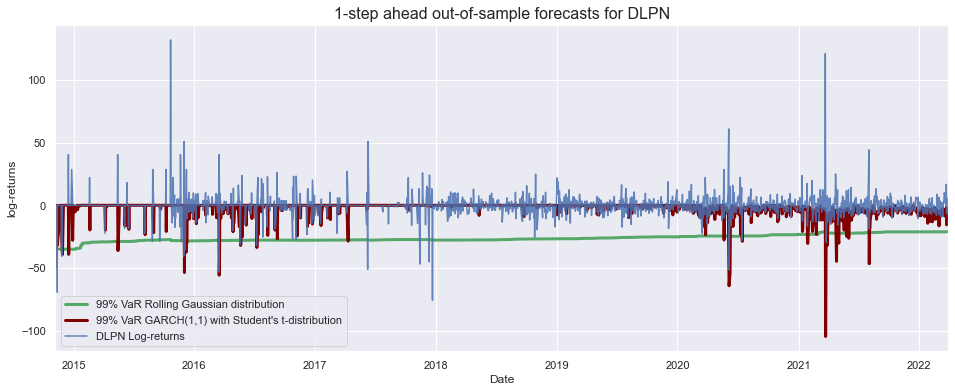

In [214]:
#What happens at DLPN?

ind = Large_VaRNormal99.loc[:,'DLPN'].dropna().index
d = np.where(pd.to_datetime(StockData.loc[:,'DLPN'].index) == ind[0])

sns.set()
sns.color_palette('dark')
plt.figure(figsize=(16,6))
plt.margins(x=0)
plt.plot(ind[1:], -Large_VaRNormal99.loc[:,'DLPN'][:-1].dropna(), color = 'g', label = '99% VaR Rolling Gaussian distribution', linewidth = 3) 
plt.plot(ind[1:], -Large_VaR_Garch_99_DF.loc[:,'DLPN'][:-1].dropna(), color = 'maroon', label = "99% VaR GARCH(1,1) with Student's t-distribution", linewidth = 3) #color = 'darkred'
plt.plot(ind[1:], StockData.loc[:,'DLPN'][d[0][0]+1:-1], color = 'b', label = 'DLPN Log-returns', alpha = 0.85) #color = 'steelblue'
plt.legend()
plt.title('1-step ahead out-of-sample forecasts for DLPN', fontsize = 16)
plt.ylabel('log-returns')
plt.xlabel('Date')
plt.show()

#There is a clear indication that the stock is illiquid and thus does not provide an adequate fit for the GARCH model. This imposes the question of using simpler VaR-based models when illiquidity (or proper data) is lacking. 

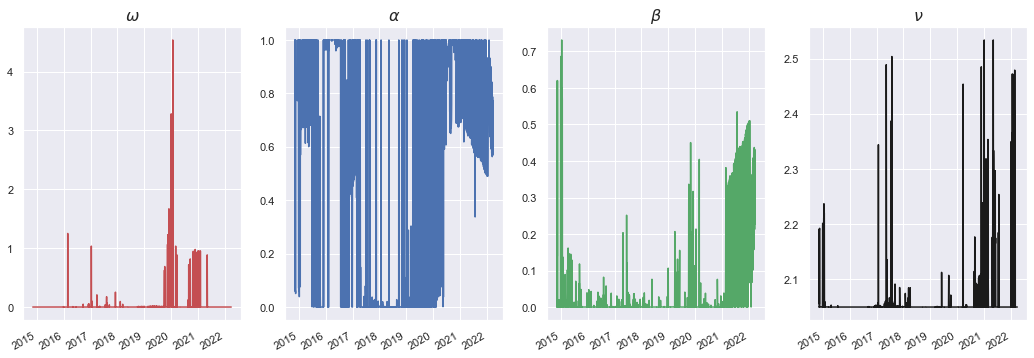

In [25]:
#Garch parameters for DLPN:
paramEstimates = Large_GARCH_Estimates_DF.loc[:,"DLPN"].dropna(axis = 0)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(18,6))

ax[0].plot(paramEstimates['omega'], 'r') #row=0, col=0
ax[1].plot(paramEstimates['alpha[1]'], 'b') #row=1, col=0
ax[2].plot(paramEstimates['beta[1]'], 'g') #row=0, col=1
ax[3].plot(paramEstimates['nu'], 'k') #row=1, col=1
ax[0].set_title(r'$\omega$', fontsize = 16)
ax[1].set_title(r'$\alpha$', fontsize = 16)
ax[2].set_title(r'$\beta$', fontsize = 16)
ax[3].set_title(r'$\nu$', fontsize = 16)

fig.autofmt_xdate()

plt.show()

# Strongly suggest the lack of 'proper' data (noisy or lacking) which also caused some rapid and spurious changes in the parameter estimates. 
# This further strengthens the claim that simpler models (maybe nonparametric ones) should be used for illiquid equities. 

In [199]:
Large_VaRViolations_Garch99_DF_NoLoss = pd.concat([VaRViolations(Large_VaR_Garch_99_DF.loc[:, name], StockData.loc[:, name], WindowLength, Loss = False) for name in names], axis = 1)
Large_VaRViolations_Garch99_DF_NoLoss.columns = names 

Large_VaRViolations_Normal99_DF_NoLoss = pd.concat([VaRViolations(Large_VaRNormal99.loc[:, name], StockData.loc[:, name], WindowLength, Loss = False) for name in names], axis = 1)
Large_VaRViolations_Normal99_DF_NoLoss.columns = names 

tempGARCH99 = {name:CoverageTest(Large_VaRViolations_Garch99_DF_NoLoss.loc[:,name], 0.01, False) for name in names}
tempNormal99 = {name:CoverageTest(Large_VaRViolations_Normal99_DF_NoLoss.loc[:,name], 0.01, False) for name in names}


UncondAndCond_Coverage_GARCH99 = pd.concat([pd.DataFrame(v) for k, v in tempGARCH99.items()], axis = 0, join = 'outer', keys = list(tempGARCH99.keys()))
UncondAndCond_Coverage_Normal99 = pd.concat([pd.DataFrame(v) for k, v in tempNormal99.items()], axis = 0, join = 'outer', keys = list(tempNormal99.keys()))

UncondAndCond_Coverage = pd.concat([UncondAndCond_Coverage_Normal99, UncondAndCond_Coverage_GARCH99], axis = 1)
UncondAndCond_Coverage.columns = pd.MultiIndex.from_product([ ["99% Gaussian", "99% GARCH"], ["Alpha hat","T-stat", "p-value"]], names = [" ", "Statistics"])

In [200]:
UncondAndCond_Coverage

99% Gaussian                      99% GARCH           \
Statistics            Alpha hat   T-stat     p-value Alpha hat   T-stat   
A    Unconditional       0.0141   6.4192  1.1289e-02    0.0106   0.1567   
     Conditional         0.0141   7.6205  2.2142e-02    0.0106   2.9198   
AA   Unconditional       0.0235  57.9786  2.6534e-14    0.0129   3.3967   
     Conditional         0.0235  79.4403  0.0000e+00    0.0129   5.0236   
AAL  Unconditional       0.0088   0.7034  4.0164e-01    0.0067   5.4513   
...                         ...      ...         ...       ...      ...   
ZNGA Conditional         0.0018      NaN         NaN    0.0014      NaN   
ZUMZ Unconditional       0.0053  11.6694  6.3538e-04    0.0051  12.9922   
     Conditional         0.0053      NaN         NaN    0.0051      NaN   
ZYXI Unconditional       0.0081   1.7508  1.8577e-01    0.0108   0.2971   
     Conditional         0.0081      NaN         NaN    0.0108      NaN   

                            
Statistics         p-value  
A    Unconditional  0.6922  
     Conditional    0.2323  
AA   Unconditional  0.0653  
     Conditional    0.0811  
AAL  Unconditional  0.0196  
...                    ...  
ZNGA Conditional       NaN  
ZUMZ Unconditional  0.0003  
     Conditional       NaN  
ZYXI Unconditional  0.5857  
     Conditional       NaN  

[4378 rows x 6 columns]

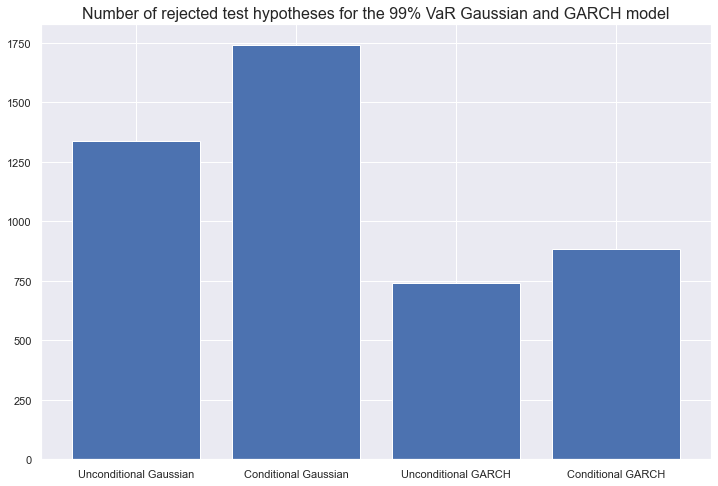

In [201]:
#Testing over multiple stocks might cause the mutliple comparison problem.
Normal99_pvals = UncondAndCond_Coverage.loc[:,["99% Gaussian"]].where(UncondAndCond_Coverage.loc[:,"99% Gaussian"].loc[:,"p-value"] < 0.01).dropna(axis = 0)
GARCH99_pvals = UncondAndCond_Coverage.loc[:,["99% GARCH"]].where(UncondAndCond_Coverage.loc[:,"99% GARCH"].loc[:,"p-value"] < 0.01).dropna(axis = 0)


xticks = ["Unconditional Gaussian", "Conditional Gaussian", "Unconditional GARCH", "Conditional GARCH"]

bars = [len(Normal99_pvals.xs('Unconditional', level=1, drop_level=False).iloc[:,2]), len(Normal99_pvals.xs('Conditional', level=1, drop_level=False).iloc[:,2]), 
len(GARCH99_pvals.xs('Unconditional', level=1, drop_level=False).iloc[:,2]), len(GARCH99_pvals.xs('Conditional', level=1, drop_level=False).iloc[:,2])]


sns.set()
sns.color_palette('dark')
plt.figure(figsize=(12,8))
plt.bar(xticks, bars)
plt.title("Number of rejected test hypotheses for the 99% VaR Gaussian and GARCH model", fontsize = 16)
plt.show()

In [146]:
#Idea, give proportion on green, yellow, red: How many days in each. 

TrafficlightGARCH99temp = {name:Large_VaRViolations_Garch99_DF_NoLoss.loc[:,name].rolling(250).sum() for name in names}
TrafficlightGARCH99 = pd.concat([pd.DataFrame(v) for k, v in TrafficlightGARCH99temp.items()], axis = 1, join = 'outer', keys = list(TrafficlightGARCH99temp.keys())).dropna()

TrafficlightNormal99temp =  {name:Large_VaRViolations_Normal99_DF_NoLoss.loc[:,name].rolling(250).sum() for name in names}
TrafficlightNormal99 = pd.concat([pd.DataFrame(v) for k, v in TrafficlightNormal99temp.items()], axis = 1, join = 'outer', keys = list(TrafficlightNormal99temp.keys())).dropna()


In [ ]:
#%%script echo skipping
TrafficlightGarch = {}
for j in range(len(names)):
    temp = []
    for i in range(len(TrafficlightGARCH99.iloc[:,j])): 

        if TrafficlightGARCH99.iloc[i,j] <= 5:
            temp.append("Green")
        if 5 < TrafficlightGARCH99.iloc[i,j] <= 10:
            temp.append("Yellow")
        if TrafficlightGARCH99.iloc[i,j] > 10:
            temp.append("Red")

    TrafficlightGarch[names[j]] = temp
    sys.stdout.write('\r'+str(j)+' of '+str(len(names)))

#Slow but works. 24m 20s

In [ ]:
#%%script echo skipping
TrafficlightNormal = {}
for j in range(len(names)):
    temp = []
    for i in range(len(TrafficlightNormal99.iloc[:,j])): 

        if TrafficlightNormal99.iloc[i,j] <= 5:
            temp.append("Green")
        if 5 < TrafficlightNormal99.iloc[i,j] <= 10:
            temp.append("Yellow")
        if TrafficlightNormal99.iloc[i,j] > 10:
            temp.append("Red")

    TrafficlightNormal[names[j]] = temp
    sys.stdout.write('\r'+str(j)+' of '+str(len(names)))

#Slow but works. 24m 20s

In [160]:
%%script echo skipping
import pickle
with open('TrafficlightGarch.pkl', 'wb') as f:
    pickle.dump(TrafficlightGarch, f)

with open('TrafficlightNormal.pkl', 'wb') as f:
    pickle.dump(TrafficlightNormal, f)

In [173]:
with open('TrafficlightGarch.pkl', 'rb') as f:
   TrafficlightGarch = pickle.load(f)

with open('TrafficlightNormal.pkl', 'rb') as g:
    TrafficlightNormal = pickle.load(g)

In [185]:
ProportionTrafficLightGarch = {name:[TrafficlightGarch[name].count("Green")/4089, TrafficlightGarch[name].count("Yellow")/4089, TrafficlightGarch[name].count("Red")/4089] for name in names}
ProportionTrafficLightNormal = {name:[TrafficlightNormal[name].count("Green")/4089, TrafficlightNormal[name].count("Yellow")/4089, TrafficlightNormal[name].count("Red")/4089] for name in names}

ProportionTrafficLightGarchDF = pd.concat([pd.DataFrame(v) for k, v in ProportionTrafficLightGarch.items()], axis = 1, join = 'outer', keys = list(ProportionTrafficLightGarch.keys()))
ProportionTrafficLightGarchDF.columns = names 
ProportionTrafficLightGarchDF.index = ["Prop Green", "Prop Yellow", "Prop Red"]

ProportionTrafficLightNormalDF = pd.concat([pd.DataFrame(v) for k, v in ProportionTrafficLightNormal.items()], axis = 1, join = 'outer', keys = list(ProportionTrafficLightNormal.keys()))
ProportionTrafficLightNormalDF.columns = names 
ProportionTrafficLightNormalDF.index = ["Prop Green", "Prop Yellow", "Prop Red"]


In [202]:
# Across 2000+ stocks the proportion for the GARCH model is 10 percentage point higher at the Green zone than the Gaussian VaR model. Moreover, the 99% VaR for the GARCH model has almost no indication of being in the red zone.
Table3 = pd.concat([ProportionTrafficLightNormalDF.mean(axis = 1), ProportionTrafficLightGarchDF.mean(axis = 1)], axis = 1)
Table3.columns = ["Gaussian 99% VaR", "GARCH 99% VaR"]
Table3

,Gaussian 99% VaR,GARCH 99% VaR
Prop Green,0.8262,0.9243
Prop Yellow,0.0851,0.0705
Prop Red,0.0887,0.0052
